# 11. Logistic Regression

The Logistic Regression, also called a logit model, is a method for fitting a regression curve $y=f(x)$ in which the response variable (dependent variable) $y$ is a **categorical** variable (dichotomous outcome variable) such as True/False or 0/1. 

In the logit model it actually measures the **log odds** of the outcome given a linear combination of a set of predictors $x$. The predictors can be continuous, categorical or a mix of both.

The categorical variable y, in general, can assume different values. In the simplest case scenario y is binary meaning that it can assume either the value 1 (Yes) or 0 (No). In this post we call the model “binomial logistic regression”, however, logistic regression can also be used to predict an outcome with more than 2 categories. In this second case we call the model “multinomial logistic regression”. A typical example for instance, would be classifying marketing campaign between “failure”, “non existent” or “success”.

## Implementation in R

Logistic regression is implemented in R using `glm()` by predicting the primary outcome of interest using features or variables in the dataset.

* `formula` - specify the relationship between variables and the outcome of interest
* `data` - the dataset used to train the model 
* `family` - R object to specify the details of the model. In logistic regression, its value is binomial


## The Dataset 
We would use a dataset from the 2021 National Youth Tobacco Survey (NYTS) in the `RforHDSdata` package called `nyts`. This dataset contains 20,413 participants and a set of variables relating to demographic information, frequency of tobacco use, and methods of obtaining said tobacco as reported by students on the 2021 NYTS. One question from this study was whether subjects used e-cigarettes in the past 30 days. The objective of the logistic regression model is to predict whether they used or not based on the predictor variables, such as demographic information. We add a new column `e_cig_use`, as our outcome of interest, which is equal to 0 if respondent answered with "No" and 1 otherwise. 

In [14]:
library(RforHDSdata)
data(nyts)

In [15]:
nyts$e_cig_use <- ifelse(nyts$num_e_cigs==0, "0", "1")
nyts$e_cig_use <- as.factor(nyts$e_cig_use)

In [26]:
nyts.sub <- nyts[,c("age", "sex", "race_and_ethnicity", "LGBT", "num_cigarettes", "family_affluence", "e_cig_use")]

nyts.sub <- nyts[complete.cases(nyts),]

## Model Fitting

In [27]:
nyts$age <- as.numeric(nyts$age)
model1 <- glm(e_cig_use ~ age + sex + race_and_ethnicity + LGBT + num_cigarettes + family_affluence, 
              data = nyts.sub, 
              family = "binomial")
summary(model1)

Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = e_cig_use ~ age + sex + race_and_ethnicity + LGBT + 
    num_cigarettes + family_affluence, family = "binomial", data = nyts.sub)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.2819   0.0000   0.0000   0.0000   3.1672  

Coefficients:
                                           Estimate Std. Error z value Pr(>|z|)
(Intercept)                                -27.8298  2741.3072  -0.010    0.992
age                                          0.4922     0.3927   1.253    0.210
sexFemale                                  -18.6287  3171.4881  -0.006    0.995
race_and_ethnicitynon-Hispanic Black       -17.9097  5095.3009  -0.004    0.997
race_and_ethnicitynon-Hispanic other race  -17.5951  8395.2423  -0.002    0.998
race_and_ethnicitynon-Hispanic White        -0.5590     1.4356  -0.389    0.697
LGBTNot Sure                                19.3756  2741.3053   0.007    0.994
LGBTYes                                     19.4744  2741.3053   0.007    0.994


The output shows the coefficients for predictors, their standard errors, the z-statistic (sometimes called a Wald z-statistic), and the associated p-values. For example, `num_cigarettes`, `age` and `sex` are statistically significant, as their p-values are less than our default significance level ($\alpha = 0.05$). The logistic regression coefficients give the change in the log odds of the outcome for a one unit increase in the predictor variable.

* For every one unit change in `age`, the log odds of smoking e-cigarettes in the past 30 days decreases by 5.60527.
* For a one unit increase in `num_cigarettes`, the log odds of smoking e-cigarettes in the past 30 days increases by 0.28979.
* For indicator variables, we will have a slightly different interpretation. For example, the categorical variable with value of 1, versus value of 0, changes the log odds of outcome by certain coeffcients amount. The log odds of  smoking e-cigarettes in the past 30 days among females is higher 0.24414 than the log odds of smoking among males. 

Below the table of coefficients are fit indices, including the null and deviance residuals and the AIC. Later we show an example of how you can use these values to help assess model fit.

## Diagnostic Plots
Next we see the deviance residuals, which are a measure of model fit. The first part of the above output shows the distribution of the deviance residuals for individual cases used in the model. Below we discuss how to use summaries of the deviance statistic to assess model fit. Let’s look at the residuals from this model. Change type to “deviance” below to get the deviance residuals.

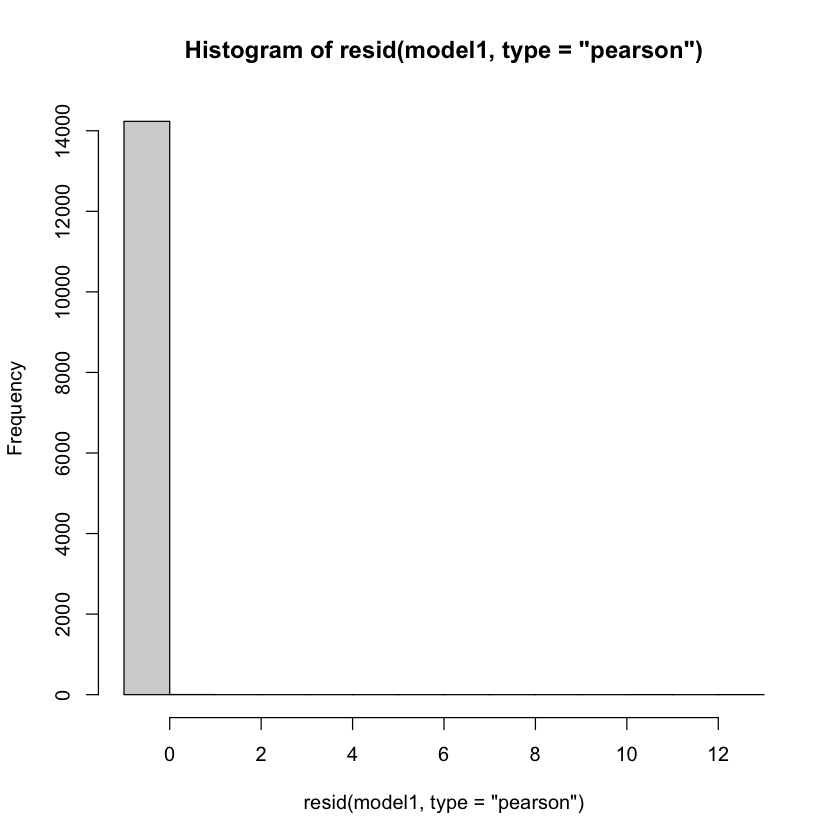

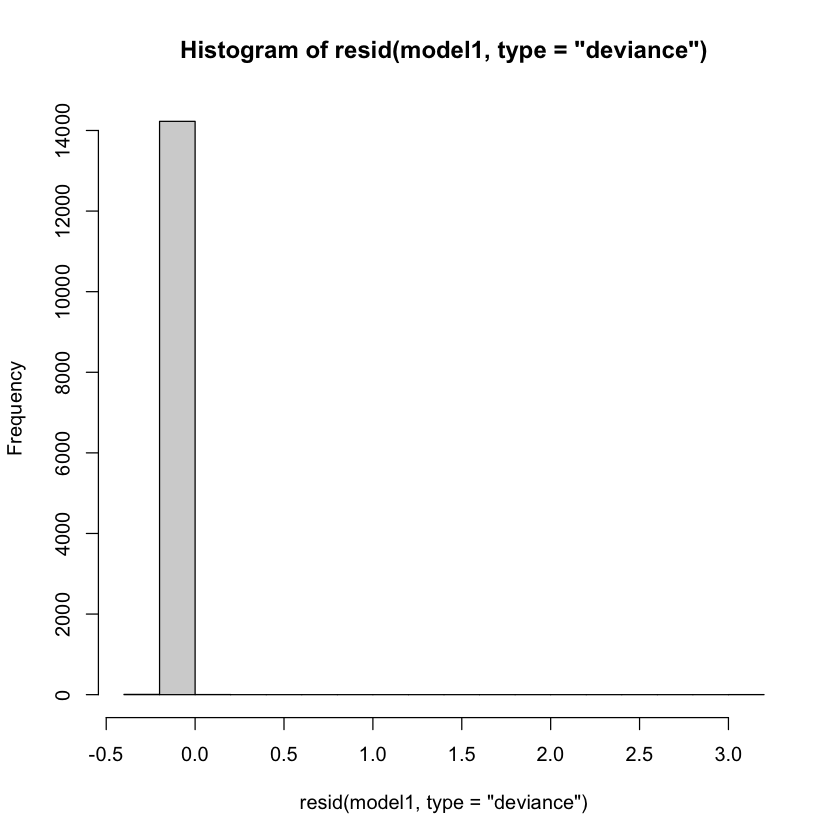

In [28]:
hist(resid(model1, type="pearson"))
hist(resid(model1, type="deviance"))

## Predictability of the Model

In the steps above, we briefly evaluated the fitting of the model, now we would like to find the predicted
probabilities. By setting the parameter type='response', R will output probabilities in the form of P(y=1|X). Our decision boundary will be 0.5. If P(y=1|X) > 0.5 then y = 1 otherwise y=0. Note that for some applications different thresholds could be a better option. When we add in `type=“response”` to the code below it indicates that we want the predicted probabilities instead of the predicted log odds.

In [31]:
length(complete.cases(pred_ys))
sum(complete.cases(nyts.sub))
length(pred_probs)

[1] 14239

[1] 14239

[1] 14239

In [33]:
pred_probs <- predict(model1, type="response")
pred_ys <- ifelse(pred_probs > 0.5, 1, 0)
table(na.omit(nyts.sub$e_cig_use), pred_ys)

misClasificError <- mean(pred_ys != nyts.sub$e_cig_use)
print(paste('Accuracy', 1-misClasificError))
# simple table, sensitivity

   pred_ys
        0     1
  0 14234     0
  1     2     3

[1] "Accuracy 0.999859540698083"


The 0.99986 accuracy on the test set is quite a good result. Then, let's still observe the accuracy. 

We can also check the calibration. The code below plots a calibration plot. We have to add the predicted
probabilities to the data frame to use this function.

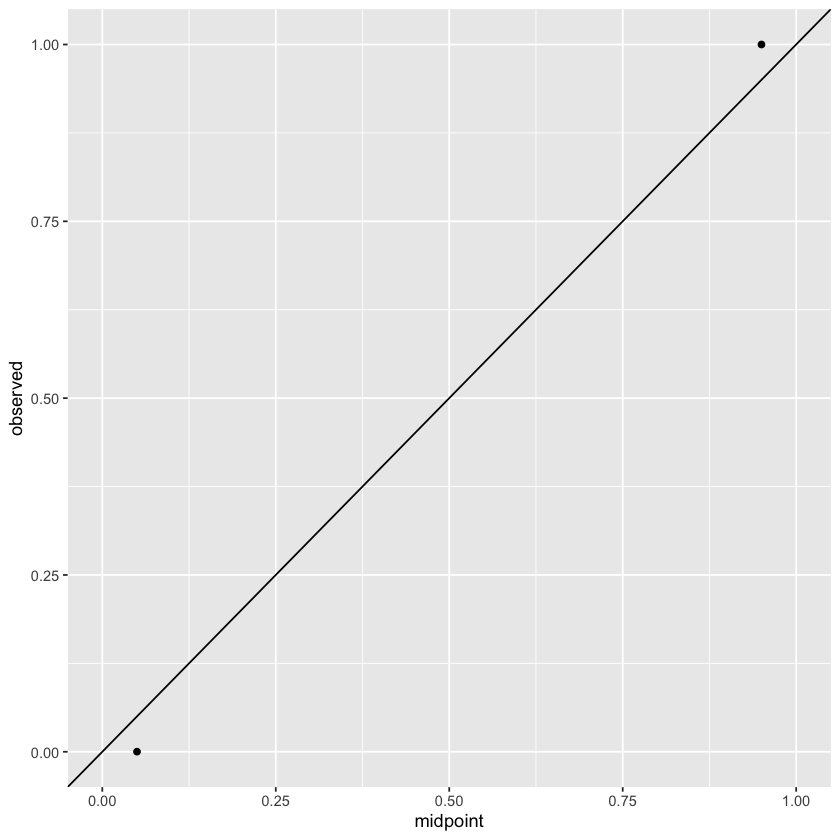

In [36]:
library(tidyverse)
# cut functions
# summarize it via tidyverse
# nyts$pred <- pred_probs
# calibration_plot(data = nyts, obs = "e_cig_use", pred = "pred")

nyts.sub$pred_probs <- predict(model1, type="response")
num_cuts <- 10
cuts <- (0:num_cuts)/num_cuts
binData <-  data.frame(prob = nyts.sub$pred_probs,
                      bin = cut(nyts.sub$pred_probs, cuts, include.lowest = TRUE),
                      class = nyts.sub$e_cig_use)
midpoints =seq(1/(2*num_cuts),1-1/(2*num_cuts), 1/num_cuts)
names(midpoints)=levels(binData$bin)
binData$midpoint <- unname(midpoints[binData$bin])
binData <- binData %>% 
             group_by(midpoint) %>% 
             summarize(observed = sum(class == 1)/n())
ggplot(binData) + 
  geom_abline(intercept = 0, slope = 1) + 
  ylim(0, 1) + 
  xlim(0,1) + 
  geom_point(aes(x = midpoint, y = observed))

As a last step, we are going to plot the *ROC* curve and calculate the *AUC* (area under the curve) which are typical performance measurements for a binary classifier. As a rule of thumb, a model with good predictive ability should have an AUC closer to 1 (1 is ideal) than to 0.5.

In [ ]:
library(pROC)
roc_mod <- roc(predictor=pred_probs, response=nyts$e_cig_use)
plot(roc_mod, print.auc=TRUE)

# TODO: different cutoff point - at ROC curve 

In [ ]:
# stepwise function 
step(model1, direction = 'backward', trace = 0)

## Exercises:

1. Try using `lm` for analyzing the smoking behavior as a function of variables in the `nyts` data. They can be random from your favorite or interested potential predictors. Fit a Logistic regression to your subset of data frame using `glm`. Are the estimated coefficients similar to the true ones we used?

2. What is the estimated probability of an event at x=1,1? Use `predict()` function but make sure to read the documentation on the type argument.

3. Measure accuracy and precision of your model.